# Data reduction for the hap-fr channel

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord,Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

from pathlib import Path

In [3]:
#from gammapy.detect import compute_lima_on_off_image

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)


from gammapy.modeling.models import (
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel
)
from gammapy.modeling import Fit


import gammapy
gammapy.__version__

'0.18.2'

In [4]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

In [5]:
path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathm = Path(path/"mapdatasets")
pathm.mkdir(exist_ok=True)

patho = Path(path/"offsets")
patho.mkdir(exist_ok=True)

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

In [6]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/ash_stereo_Prod17_Calib0834_thsq64")
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/samuel/code/gammapy_data/ash_stereo_Prod17_Calib0834_thsq64
Rows: 127056
OBS_ID: 18092 -- 154591
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_2d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 21186



## Data selection

In [7]:
# Sky region selection : observation pointing within this region will be selected 
#(this can be redundant with maximum offset selection, but using the max_offset should be prefered)

from astropy.coordinates import Angle

selection = dict(type='sky_circle', frame='galactic',
                 lon=Angle(0, 'deg'),
                 lat=Angle(0, 'deg'),
                 radius=Angle(1.8, 'deg'),
                 border=Angle(0, 'deg'))


# selecting the admitted range of zenithal angle, such selection can be done for any column of the obs_table
selectionZEN = dict(type='par_box', variable='ZEN_PNT', value_range=Angle([0.,50.], 'deg'))

obs_table = data_store.obs_table.select_observations(selection)
obs_table = obs_table.select_observations(selectionZEN)

In [8]:
# Removing observations lacking IRFs (effective area, energy dispersion, point spread function and background model)

ids = obs_table["OBS_ID"].tolist()

#weird, irf missing for these ones, but it can't detect it normally somehow
ids.remove(31539)
ids.remove(31577)
ids.remove(31578)
ids.remove(31579)
ids.remove(31580)

observations = data_store.get_observations(ids, skip_missing=True)

for obs in observations:
    try:
        obs.aeff
        obs.edisp
        obs.psf
        obs.bkg   
    except:
        ids.remove(obs.obs_id)
        print("Removed observation : " + str(obs.obs_id))
        
observations = data_store.get_observations(ids, skip_missing=True)
obs_table = obs_table.select_obs_id(ids)

Removed observation : 129467
Removed observation : 129471
Removed observation : 153792
Removed observation : 146971
Removed observation : 147119
Removed observation : 151790
Removed observation : 153030
Removed observation : 153031
Removed observation : 153791
Removed observation : 153793
Removed observation : 153794
Removed observation : 153810
Removed observation : 153811
Removed observation : 153812
Removed observation : 153813
Removed observation : 153836
Removed observation : 153837
Removed observation : 153838
Removed observation : 153839
Removed observation : 153840
Removed observation : 153841


## Observations en fonction du temps

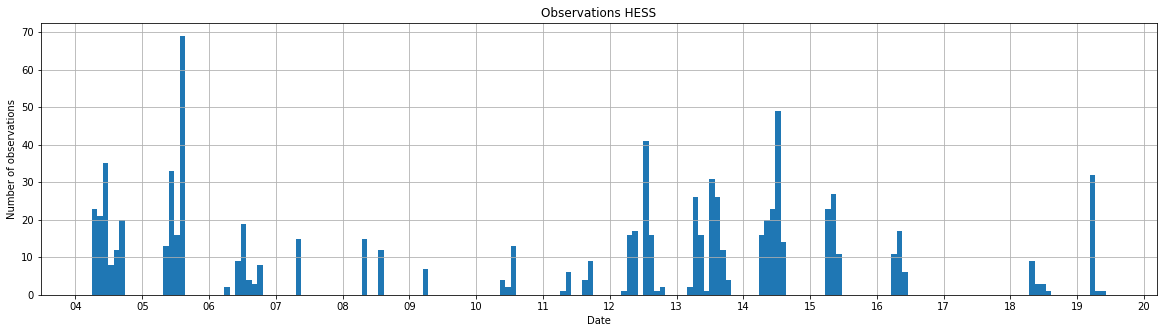

In [14]:
import matplotlib.dates as dates

data=obs_table["DATE_OBS"].tolist()
mpl_data = dates.datestr2num(data)

bins = int((mpl_data[-1] - mpl_data[0])/30)

fig, ax = plt.subplots(1,1,figsize=(20,5)) 
ax.hist(mpl_data ,bins=bins)

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('%y'))

  
plt.title('Observations HESS')
plt.grid()
plt.xlabel("Date")
plt.ylabel("Number of observations")
    
name = "date-obs_hesstot_fr.pdf"
plt.savefig(path/name, overwrite=True)

In [11]:
obs_table

AIRTEMP,ALT_PNT,AZ_PNT,BKG_SCALE,BROKPIX,DATE_END,DATE_OBS,DEADC,DEC_OBJ,DEC_PNT,EFFAREA_MAX,EFFAREA_RECO_MAX,EVENT_COUNT,EVENT_DEC_MEDIAN,EVENT_ENERGY_MEDIAN,EVENT_RA_MEDIAN,EVENT_TIME_MAX,EVENT_TIME_MIN,GLAT_PNT,GLON_PNT,HI_THRES,LIVETIME,LO_THRES,MUONEFF,NSBLEVEL,N_TELS,OBJECT,OBS_ID,ONTIME,PRESSURE,QUALITY,RA_OBJ,RA_PNT,RELHUM,TELLIST,TIME_END,TIME_OBS,TMID,TMID_STR,TRGRATE,TSTART,TSTART_STR,TSTOP,TSTOP_STR,ZEN_PNT,ZTRGRATE,TC
degC,deg,deg,,,,,,deg,deg,,,,deg,TeV,deg,s,s,deg,deg,,s,,,,,,,s,hPa,,deg,deg,,,,,days,,Hz,s,,s,,deg,Hz,
float32,float32,float32,float32,float32,bytes10,bytes10,float32,float32,float32,float64,float64,int64,float32,float32,float32,float64,float64,float32,float32,int64,float32,int64,float32,float32,int64,bytes43,int64,float32,float32,int64,float32,float32,float64,bytes9,bytes8,bytes8,float32,bytes1,float32,float32,bytes19,float32,bytes19,float32,float32,float32
13.63296,90.0,180.0,-1.0,0.001302083,2004-03-30,2004-03-30,0.929656,-28.805,-28.305,718303.125,-1.0,3115,-28.415556,0.848989,266.24484,102300533.21896029,102298851.6202147,0.40773767,0.49051896,150,1562.7518,-1,0.83095795,-1000000.0,4,Sgr A,20193,1681.0,822.0289,0,266.3,266.3,0.30414310455322263,"1,2,3,4",00:03:57,00:03:56,-1.0,,231.12474,102298850.0,2004-03-30 00:20:52,102300536.0,2004-03-30 00:48:53,47.70625,-1.0,-1.0
14.1437,90.0,180.0,-1.0,0.001302083,2004-03-30,2004-03-30,0.92225224,-28.805,-29.305,530784.8125,-1.0,4297,-29.349417,0.61821836,266.27734,102302344.48098135,102300662.06362748,-0.11404082,359.63742,150,1550.306,-1,0.83095795,-1000000.0,4,Sgr A,20194,1681.0,821.7823,0,266.3,266.3,0.29267780303955077,"1,2,3,4",01:03:08,00:03:07,-1.0,,250.57875,102300664.0,2004-03-30 00:51:03,102302344.0,2004-03-30 01:19:04,41.05625,-1.0,-1.0
14.54974,90.0,180.0,-1.0,0.0046875,2004-03-30,2004-03-30,0.91425073,-28.805,-28.305,419600.4375,-1.0,5241,-28.353394,0.4487548,266.35065,102304164.61427951,102302483.26455379,0.40773767,0.49051896,150,1536.8555,-1,0.83095795,-1000000.0,4,Sgr A,20195,1681.0,821.8443,0,266.3,266.3,0.28079959869384763,"1,2,3,4",01:03:28,01:03:27,-1.0,,264.39474,102302480.0,2004-03-30 01:21:23,102304160.0,2004-03-30 01:49:24,34.719986,-1.0,-1.0
15.21348,90.0,180.0,-1.0,0.001302083,2004-03-30,2004-03-30,0.90476674,-28.805,-29.305,262482.4375,-1.0,6143,-29.370905,0.29340225,266.36508,102309606.69723678,102307924.0854094,-0.11404082,359.63742,150,1520.9128,-1,0.83095795,-1000000.0,4,Sgr A,20198,1681.0,822.0146,0,266.3,266.3,0.2612815093994141,"1,2,3,4",03:03:10,02:03:09,-1.0,,286.9615,102307930.0,2004-03-30 02:52:05,102309610.0,2004-03-30 03:20:06,15.265533,-1.0,-1.0
14.79698,90.0,180.0,-1.0,0.0046875,2004-03-30,2004-03-30,0.89993525,-28.805,-28.305,245122.5625,-1.0,4249,-28.345642,0.2863966,266.39352,102311173.89032936,102309741.54700351,0.40773767,0.49051896,150,1288.7073,-1,0.83095795,-1000000.0,4,Sgr A,20199,1432.0,822.0317,0,266.3,266.3,0.26916070938110354,"1,2,3,4",03:03:18,03:03:26,-1.0,,296.54373,102309740.0,2004-03-30 03:22:22,102311176.0,2004-03-30 03:46:14,9.241486,-1.0,-1.0
16.51259,90.0,180.0,-1.0,0.00625,2004-04-26,2004-04-26,0.9003915,-29.007833,-28.507833,309538.34375,-1.0,5686,-28.518177,0.34218484,266.44812,104633582.98507762,104631900.72988081,0.21442167,0.37093028,150,1513.5581,-1,0.83463657,-1000000.0,4,Sgr A*,20549,1681.0,825.0249,0,266.41666,266.41666,0.4342190170288086,"1,2,3,4",00:04:07,00:04:06,-1.0,,272.15225,104631900.0,2004-04-26 00:25:02,104633580.0,2004-04-26 00:53:03,23.842133,-1.0,-1.0
15.77368,90.0,180.0,-1.0,0.005729167,2004-04-26,2004-04-26,0.89997774,-29.007833,-29.507833,271002.40625,-1.0,6044,-29.489326,0.30608153,266.4275,104635397.70902395,104633715.8728385,-0.30651847,359.51733,150,1513.7626,-1,0.83463657,-1000000.0,4,Sgr A*,20550,1682.0,825.0353,0,266.41666,266.41666,0.4619076919555664,"1,2,3,4",01:04:22,00:04:20,-1.0,,272.71375,104633710.0,2004-04-26 00:55:16,104635400.0,2004-04-26 01:23:18,17.490547,-1.0,-1.0
15.61296,90.0,180.0,-1.0,0.006510417,2004-04-26,2004-04-26,0.9031135,-29.007833,-

### Time intervals

In [24]:
#time intervals used for selection

t2004  = dict(type='time_box', time_range= Time(['2004-01-01T00:00:00', '2004-12-31T23:59:59']))
t2005  = dict(type='time_box', time_range= Time(['2005-01-01T00:00:00', '2005-12-31T23:59:59']))
t2006  = dict(type='time_box', time_range= Time(['2006-01-01T00:00:00', '2006-12-31T23:59:59']))
t2007  = dict(type='time_box', time_range= Time(['2007-01-01T00:00:00', '2007-12-31T23:59:59']))
t2008  = dict(type='time_box', time_range= Time(['2008-01-01T00:00:00', '2008-12-31T23:59:59']))
t2009  = dict(type='time_box', time_range= Time(['2009-01-01T00:00:00', '2009-12-31T23:59:59']))
t2010  = dict(type='time_box', time_range= Time(['2010-01-01T00:00:00', '2010-12-31T23:59:59']))
t2011  = dict(type='time_box', time_range= Time(['2011-01-01T00:00:00', '2011-12-31T23:59:59']))
t2012  = dict(type='time_box', time_range= Time(['2012-01-01T00:00:00', '2012-12-31T23:59:59']))
t2013  = dict(type='time_box', time_range= Time(['2013-01-01T00:00:00', '2013-12-31T23:59:59']))
t2014  = dict(type='time_box', time_range= Time(['2014-01-01T00:00:00', '2014-12-31T23:59:59']))
t2015  = dict(type='time_box', time_range= Time(['2015-01-01T00:00:00', '2015-12-31T23:59:59']))
t2016  = dict(type='time_box', time_range= Time(['2016-01-01T00:00:00', '2016-12-31T23:59:59']))
t2017  = dict(type='time_box', time_range= Time(['2017-01-01T00:00:00', '2017-12-31T23:59:59']))
t2018  = dict(type='time_box', time_range= Time(['2018-01-01T00:00:00', '2018-12-31T23:59:59']))
t2019  = dict(type='time_box', time_range= Time(['2019-01-01T00:00:00', '2019-12-31T23:59:59']))

year_intervals = { 2004 : t2004, 2005 : t2005, 2006 : t2006, 2007 : t2007,
                      2008 : t2008, 2009 : t2009, 2010 : t2010, 2011 : t2011,
                      2012 : t2012, 2013 : t2013, 2014 : t2014, 2015 : t2015,
                      2016 : t2016, 2017 : t2017, 2018 : t2018, 2019 : t2019}

## Creating the geometry for the dataset

In [25]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, 20, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_energy_bounds(0.3, 200, 30, unit="TeV", name="energy_true")

In [26]:
# Creating the MapDataset objects

stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="stacked")


stacked_period = Datasets([MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess1"),
                           MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess1u"),
                           MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name="hess2")])

datasets_year = Datasets()

for k in range (2004,2020):
    name = f"map_{k}"
    datasets_year.append(MapDataset.create(geom=geom, energy_axis_true=energy_axis_true, name=name))

## Datasets for each year (and the complete one)

In [27]:
exclusion_region = RectangleSkyRegion(src_pos, 3*u.deg, 1*u.deg) # J1745-303 ?
exclusion_mask = geom.region_mask([exclusion_region], inside=False)
exclusion_mask = Map.from_geom(geom, data=exclusion_mask)

In [28]:
offset_max = 1.8 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(methods=["offset-max", "bkg-peak"], offset_max=offset_max)
maker_bkg = FoVBackgroundMaker("scale", exclusion_mask)

In [29]:
#histo_thresh = dict()
#for k in range(2004,2020): histo_thresh[k] = []

#histo_thresh_tot = []
#histo_thresh1 = []
#histo_thresh2 = []
#histo_thresh1u = []

In [30]:
%%time

# problems starting from 31539

for obs in observations:
    #print(f"Processing obs ID: {obs.obs_id}")
    cutout = stacked.cutout(obs.pointing_radec, width=2.0 * offset_max)

    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
        
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
        
    dataset = maker_bkg.run(dataset)
       
    year = dataset.gti.time_start.jyear.astype('int')[0]
    norm_bkg = dataset.background_model.spectral_model.norm.value
    
    if np.abs(norm_bkg - 1.) <= 0.3:
        
        datasets_year[f"map_{year}"].stack(dataset)
        stacked.stack(dataset)
        
        # Attempting to save the energy threshold (not working)
        #i = 0
        #threshold = np.max(dataset.mask_safe.data[i, :,:])
        
        #while threshold == False:
        #   i+=1
        #    threshold = np.max(dataset.mask_safe.data[0, :,:])
            
        #histo_thresh[year].append(energy_axis.edges[i].value)
        #histo_thresh_tot.append(energy_axis.edges[i].value)
        
        if (obs.obs_id > 20190 and obs.obs_id < 85000) or (obs.obs_id > 85294 and obs.obs_id < 85393):
            stacked_period["hess1"].stack(dataset)
            #histo_thresh1.append(energy_axis.edges[i].value)
                
        if (obs.obs_id > 85392 and obs.obs_id < 123635) or (obs.obs_id > 84999 and obs.obs_id < 85293):
            stacked_period["hess2"].stack(dataset)
            #histo_thresh2.append(energy_axis.edges[i].value)
                
        if (obs.obs_id > 129418 and obs.obs_id < 153843):
            stacked_period["hess1u"].stack(dataset)
            #histo_thresh1u.append(energy_axis.edges[i].value)
    #else:
    #    print(f"Bkg norm is out of bounds: {norm_bkg:.2f}. Rejecting observation {obs.obs_id}.")

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astro

CPU times: user 20min 19s, sys: 3.07 s, total: 20min 22s
Wall time: 20min 27s


In [31]:
print(obs)

Observation

	obs id            : 150146 
 	tstart            : 58643.06
	tstop             : 58643.08
	duration          : 1321.00 s
	pointing (icrs)   : 267.1 deg, -29.0 deg

	deadtime fraction : 1.7%



## Saving the datasets

In [32]:
filename = "mapdataset_tot.fits.gz"
stacked.write(pathm/filename, overwrite=True)

stacked_period.write(pathm/"datasets_period.yaml", overwrite=True)

datasets_year.write(pathm/"datasets_year.yaml", overwrite=True)

# Collecting data on observation conditions

## Offset angles

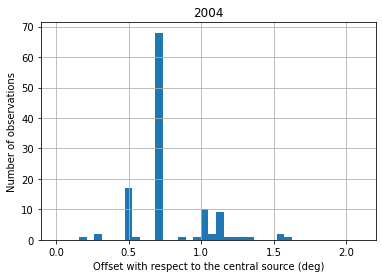

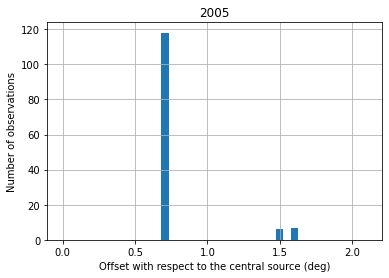

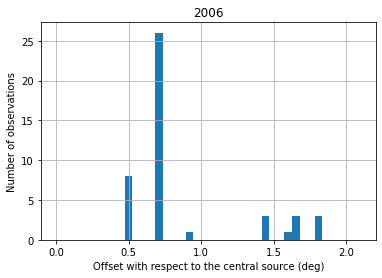

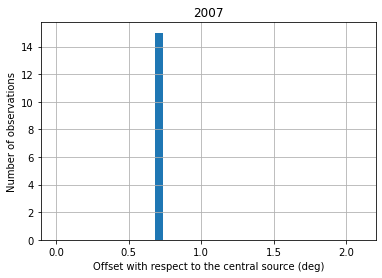

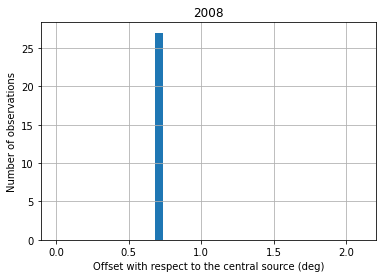

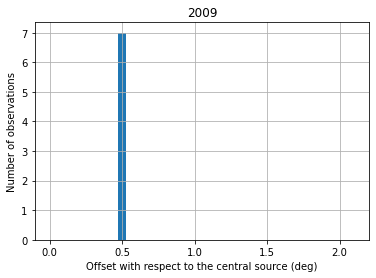

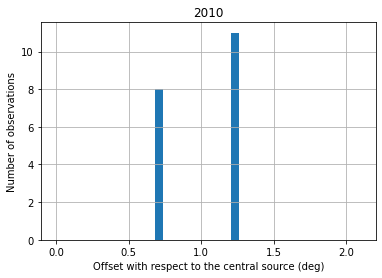

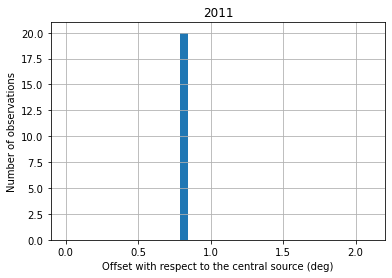

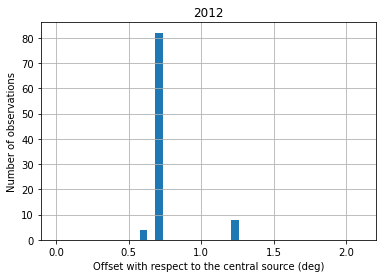

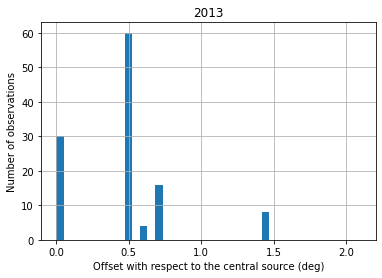

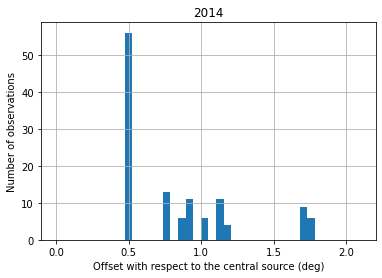

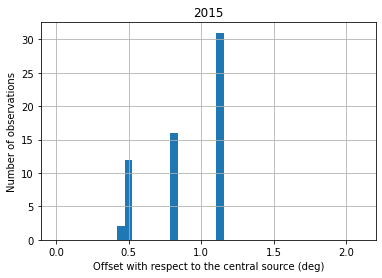

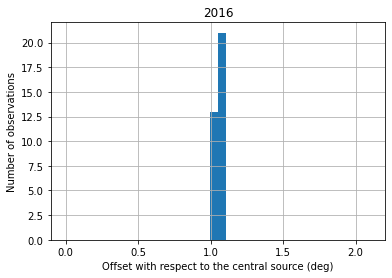

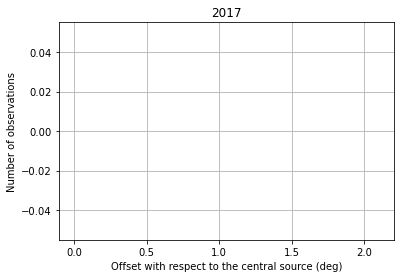

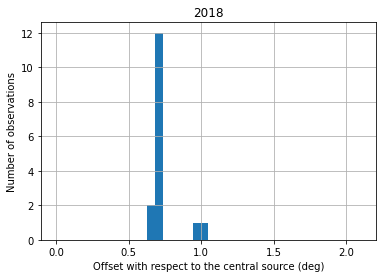

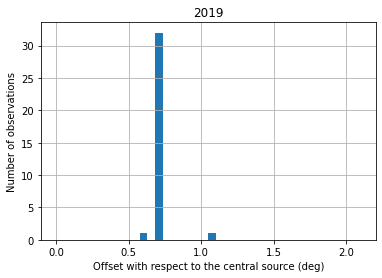

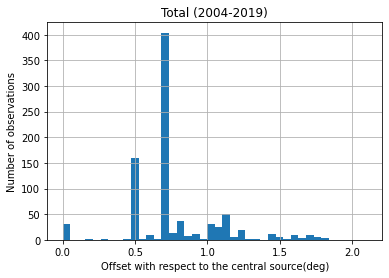

In [33]:
# Extracing offsets of observations (relative to SgrA*) for each year

sgra_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

histo_offset = dict()
offset_tot = []
offset_hess1 = []
offset_hess2 = []
offset_hess1u = []

for year in range(2004,2020):
    histo_offset[year] = []

for obs in observations:
    year = obs.gti.time_start.jyear.astype('int')[0]
    
    direction = obs.pointing_radec
    sep = direction.separation(sgra_pos) #calcule la séparation "on sky" entre les deux coordonnées
    
    histo_offset[year].append(sep.value)
    offset_tot.append(sep.value)
        
        
for year in range(2004,2020):        
    plt.figure()
    plt.hist(histo_offset[year], 40, (0.0, 2.1))
    
    plt.title(str(year))
    plt.grid()
    plt.xlabel("Offset with respect to the central source (deg)")
    plt.ylabel("Number of observations")
    
    name = "offsets_"+str(year)+"_hd.pdf"
    plt.savefig(patho/name, overwrite=True)
    

plt.figure()
plt.hist(offset_tot, 40, (0.0, 2.1))
    
plt.title("Total (2004-2019)")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_tot_hd.pdf'
plt.savefig(patho/name, overwrite=True)

In [ ]:
plt.figure()
plt.hist(offset_hess1, 40, (0.0, 2.1))
    
plt.title("Total HESS 1")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess1_hd.pdf'
plt.savefig(patho/name, overwrite=True)


plt.figure()
plt.hist(offset_hess1u, 40, (0.0, 2.1))
    
plt.title("Total HESS 1U")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess1u_hd.pdf'
plt.savefig(patho/name, overwrite=True)


plt.figure()
plt.hist(offset_hess2, 40, (0.0, 2.1))
    
plt.title("Total HESS 2")
plt.grid()
plt.xlabel("Offset with respect to the central source(deg)")
plt.ylabel("Number of observations")
name = 'offset_hess2_hd.pdf'
plt.savefig(patho/name, overwrite=True)

## Zenith angles

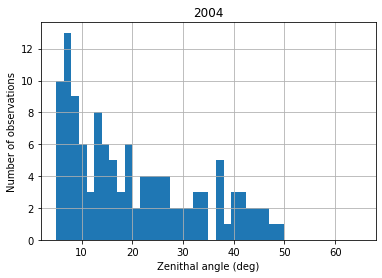

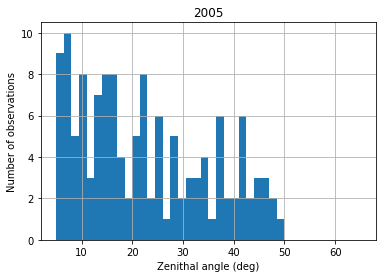

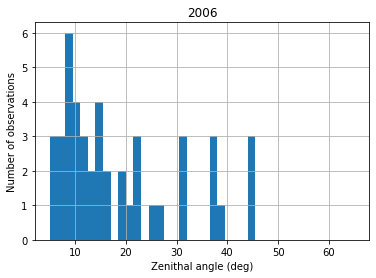

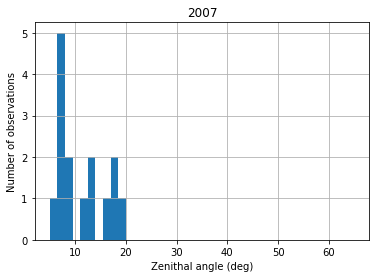

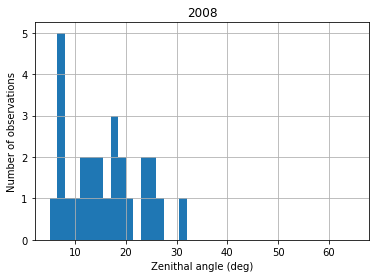

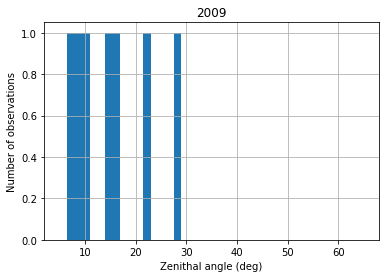

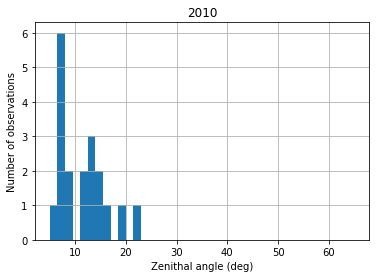

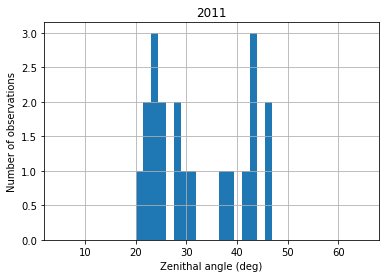

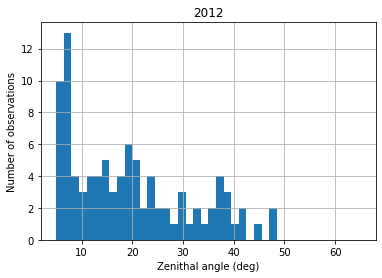

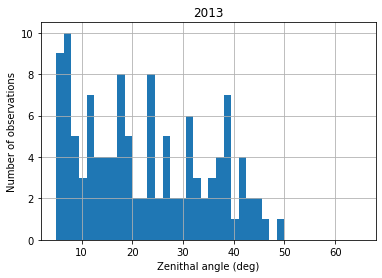

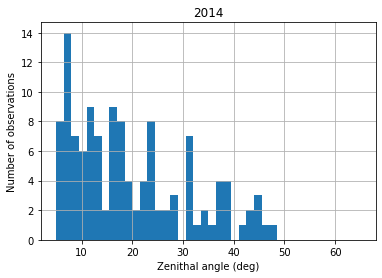

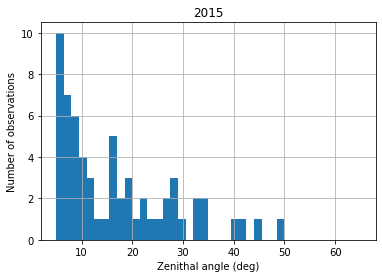

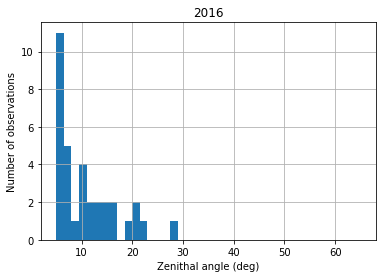

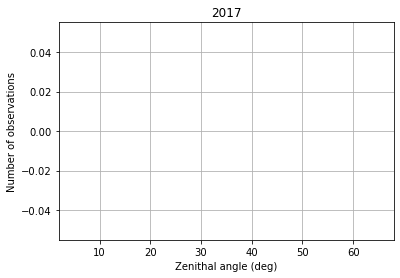

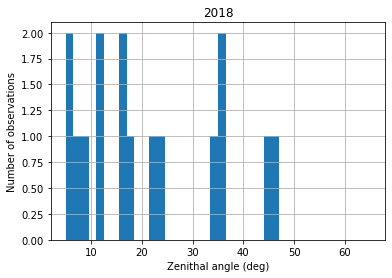

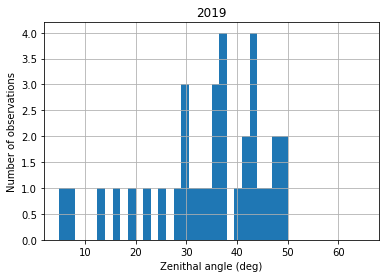

In [34]:
# Extracing zenithal angle of observation for each year

histo_zen = dict()

pathz = Path(path/"angzen")
pathz.mkdir(exist_ok=True)

for year in range(2004,2020):  
    histo_zen[year] = []
    
    obs_table_year = obs_table.select_observations(year_intervals[year])
    histo_zen[year] = obs_table_year["ZEN_PNT"].tolist()
    
    plt.figure()
    plt.hist(histo_zen[year], 40, (5.0, 65.0))
    
    plt.title(str(year))
    plt.grid()
    plt.xlabel("Zenithal angle (deg)")
    plt.ylabel("Number of observations")
    
    name = "angzen_"+str(year)+"fr.pdf"
    plt.savefig(pathz/name, overwrite=True)

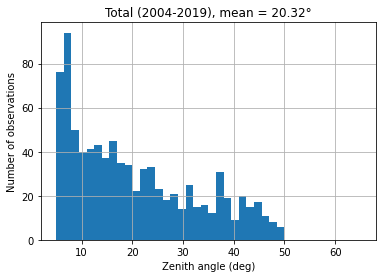

In [35]:
zen_tot = obs_table["ZEN_PNT"].tolist()
avg = np.mean(zen_tot)

plt.figure()
plt.hist(zen_tot, 40, (5.0, 65.0))
    
plt.title('Total (2004-2019), mean = {0:0.2f}°'.format(avg))
plt.grid()
plt.xlabel("Zenith angle (deg)")
plt.ylabel("Number of observations")

 
name = "angzen_tot_fr.pdf"
plt.savefig(pathz/name, overwrite=True)

## Adding up LiveTime for each year

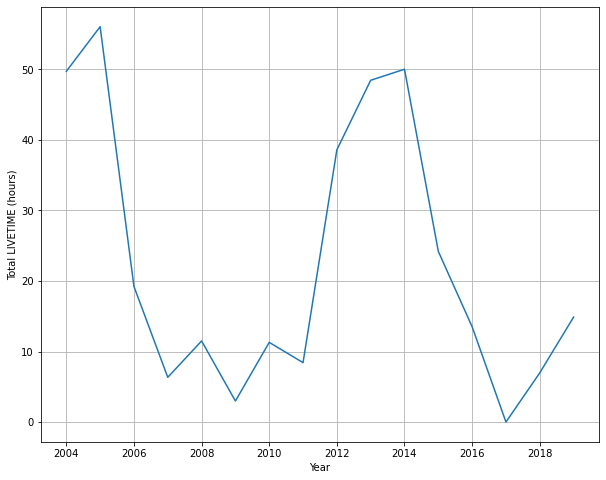

In [36]:
res = []

for year in range(2004,2020):
    obs_table_year = obs_table.select_observations(year_intervals[year])
    res.append(sum(obs_table_year["LIVETIME"].tolist())/3600)


plt.figure(figsize=(10,8))

plt.plot(range(2004,2020), res)
plt.grid()
plt.xlabel("Year")
plt.ylabel("Total LIVETIME (hours)")
    
name = path/"livetime_plot_fr.pdf"
plt.savefig(name, overwrite=True)

## Energy thresholds